# 1. Check data loss

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

def pad_to_shape(array, target_shape):
    """Pad array to target shape with zeros"""
    if array.shape == target_shape:
        return array
    
    padded = np.zeros(target_shape, dtype=array.dtype)
    slices = tuple(slice(0, min(array.shape[i], target_shape[i])) for i in range(len(target_shape)))
    padded[slices] = array[slices]
    return padded

def process_single_file(file_path):
    """Process a single EEG file and return data loss statistics"""
    try:
        # Load data
        data = np.load(file_path, allow_pickle=True)
        eeg = data["data"].squeeze()
        fs = float(data["Fs"])
        ch_names = list(data["labels"])
        art = data["artifacts"]
        
        # Extract metadata from filename
        filename = os.path.basename(file_path)
        parts = filename.split('_')
        subject_id = parts[0].replace('sub-', '')
        session = parts[1].replace('ses-', '')
        condition = 'EC' if 'EC' in filename else 'EO' if 'EO' in filename else 'Unknown'
        
        # Separate different types of artifacts
        channel_artifacts = {}  # bad/bridging/empty channels
        temporal_artifacts = {}  # time-based artifact masks
        
        for k, v in art.items():
            if k in ['bad channels', 'bridging channels', 'empty channels']:
                # Handle channel-specific artifacts
                if isinstance(v, np.ndarray) and v.size > 0:
                    channel_artifacts[k] = list(v)
                elif isinstance(v, list) and len(v) > 0:
                    channel_artifacts[k] = v
                else:
                    channel_artifacts[k] = []
            elif isinstance(v, np.ndarray) and v.size > 0:
                # Handle temporal artifact masks
                temporal_artifacts[k] = v
        
        # Process temporal artifacts (your original approach)
        if not temporal_artifacts:
            # No temporal artifacts detected
            global_mask = np.zeros(eeg.shape[1], dtype=bool)
        else:
            masks = list(temporal_artifacts.values())
            max_ch = max(m.shape[0] for m in masks)
            max_tm = max(m.shape[1] for m in masks)
            aligned = [pad_to_shape(m, (max_ch, max_tm)) for m in masks]
            global_mask = np.any(np.stack(aligned, axis=0), axis=0).any(axis=0)
        
        # Calculate channel-based quality metrics
        bad_channels = channel_artifacts.get('bad channels', [])
        bridging_channels = channel_artifacts.get('bridging channels', [])
        empty_channels = channel_artifacts.get('empty channels', [])
        
        total_channels = len(ch_names)
        bad_channel_count = len(bad_channels)
        bridging_channel_count = len(bridging_channels)
        empty_channel_count = len(empty_channels)
        
        # Calculate effective channel loss
        problematic_channels = set(bad_channels + bridging_channels + empty_channels)
        effective_channels = total_channels - len(problematic_channels)
        channel_loss_percent = (len(problematic_channels) / total_channels) * 100 if total_channels > 0 else 0
        
        # Calculate statistics
        total_samples = eeg.shape[1]
        artifact_samples = global_mask.sum()
        clean_samples = total_samples - artifact_samples
        
        data_loss_percent = (artifact_samples / total_samples) * 100
        clean_duration_sec = clean_samples / fs
        total_duration_sec = total_samples / fs
        
        # Find continuous clean segments
        clean_segments = find_continuous_segments(~global_mask, min_length=int(fs*5))  # 5-second minimum
        n_clean_segments = len(clean_segments)
        longest_segment_sec = max((seg[1] - seg[0]) / fs for seg in clean_segments) if clean_segments else 0
        
        # Combined quality assessment (temporal + spatial)
        combined_loss = data_loss_percent + (channel_loss_percent * 0.5)  # Weight channel loss at 50%
        
        if combined_loss < 10:
            quality = "Excellent"
            quality_score = 4
        elif combined_loss < 20:
            quality = "Good"
            quality_score = 3
        elif combined_loss < 30:
            quality = "Acceptable"
            quality_score = 2
        elif combined_loss < 50:
            quality = "Poor"
            quality_score = 1
        else:
            quality = "Unacceptable"
            quality_score = 0
        
        # Per-artifact-type analysis for temporal artifacts
        artifact_breakdown = {}
        for k, mask in temporal_artifacts.items():
            if mask.ndim == 2:
                artifact_samples_k = np.any(mask, axis=0).sum()
            else:
                artifact_samples_k = mask.sum()
            artifact_breakdown[k] = (artifact_samples_k / total_samples) * 100
        
        return {
            'subject_id': subject_id,
            'session': session,
            'condition': condition,
            'filename': filename,
            'n_channels': eeg.shape[0],
            'sampling_rate': fs,
            'total_duration_sec': total_duration_sec,
            'clean_duration_sec': clean_duration_sec,
            'data_loss_percent': data_loss_percent,
            'channel_loss_percent': channel_loss_percent,
            'combined_loss_percent': combined_loss,
            'quality': quality,
            'quality_score': quality_score,
            'n_clean_segments': n_clean_segments,
            'longest_segment_sec': longest_segment_sec,
            'effective_channels': effective_channels,
            'bad_channels_count': bad_channel_count,
            'bridging_channels_count': bridging_channel_count,
            'empty_channels_count': empty_channel_count,
            'bad_channels': ';'.join(bad_channels) if bad_channels else '',
            'bridging_channels': ';'.join(bridging_channels) if bridging_channels else '',
            'empty_channels': ';'.join(empty_channels) if empty_channels else '',
            'temporal_artifact_types': len(temporal_artifacts),
            'temporal_artifacts': ';'.join(temporal_artifacts.keys()),
            **{f'artifact_{k}_percent': v for k, v in artifact_breakdown.items()},
            'processing_status': 'Success'
        }
        
    except Exception as e:
        filename = os.path.basename(file_path)
        parts = filename.split('_')
        subject_id = parts[0].replace('sub-', '') if len(parts) > 0 else 'Unknown'
        condition = 'EC' if 'EC' in filename else 'EO' if 'EO' in filename else 'Unknown'
        
        return {
            'subject_id': subject_id,
            'session': 'Unknown',
            'condition': condition,
            'filename': filename,
            'processing_status': f'Error: {str(e)}',
            'data_loss_percent': np.nan,
            'quality_score': np.nan
        }

def find_continuous_segments(clean_mask, min_length=1000):
    """Find continuous segments of clean data"""
    segments = []
    in_segment = False
    start_idx = 0
    
    for i, is_clean in enumerate(clean_mask):
        if is_clean and not in_segment:
            start_idx = i
            in_segment = True
        elif not is_clean and in_segment:
            if i - start_idx >= min_length:
                segments.append((start_idx, i))
            in_segment = False
    
    # Handle case where segment extends to end
    if in_segment and len(clean_mask) - start_idx >= min_length:
        segments.append((start_idx, len(clean_mask)))
    
    return segments

def batch_process_participants(data_directory, output_dir='data_quality_analysis'):
    """
    Process all participants and generate comprehensive analysis
    """
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Find all .npy files
    pattern = os.path.join(data_directory, "**", "*.npy")
    file_paths = glob.glob(pattern, recursive=True)
    
    print(f"Found {len(file_paths)} EEG files to process...")
    
    # Process all files
    results = []
    for file_path in tqdm(file_paths, desc="Processing files"):
        result = process_single_file(file_path)
        results.append(result)
    
    # Convert to DataFrame
    df = pd.DataFrame(results)
    
    # Save raw results
    csv_path = os.path.join(output_dir, 'data_quality_summary.csv')
    df.to_csv(csv_path, index=False)
    print(f"Results saved to: {csv_path}")
    
    # Generate analysis and plots
    generate_analysis_report(df, output_dir)
    
    return df

def generate_analysis_report(df, output_dir):
    """Generate comprehensive analysis report with plots"""
    
    # Filter successful processing only for main analysis
    df_success = df[df['processing_status'] == 'Success'].copy()
    
    print(f"\\n=== DATA QUALITY ANALYSIS REPORT ===")
    print(f"Total files processed: {len(df)}")
    print(f"Successfully processed: {len(df_success)}")
    print(f"Failed processing: {len(df) - len(df_success)}")
    
    if len(df_success) == 0:
        print("No files processed successfully!")
        return
    
    # Overall statistics
    print(f"\\n=== OVERALL STATISTICS ===")
    print(f"Mean data loss: {df_success['data_loss_percent'].mean():.1f}% ± {df_success['data_loss_percent'].std():.1f}%")
    print(f"Median data loss: {df_success['data_loss_percent'].median():.1f}%")
    print(f"Range: {df_success['data_loss_percent'].min():.1f}% - {df_success['data_loss_percent'].max():.1f}%")
    
    # Quality distribution
    quality_counts = df_success['quality'].value_counts()
    print(f"\\n=== QUALITY DISTRIBUTION ===")
    for quality, count in quality_counts.items():
        percentage = (count / len(df_success)) * 100
        print(f"{quality}: {count} files ({percentage:.1f}%)")
    
    # Condition comparison
    if 'condition' in df_success.columns:
        print(f"\\n=== CONDITION COMPARISON ===")
        condition_stats = df_success.groupby('condition')['data_loss_percent'].agg(['count', 'mean', 'std'])
        print(condition_stats)
    
    # Create comprehensive plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('EEG Data Quality Analysis Across All Participants', fontsize=16, fontweight='bold')
    
    # Plot 1: Data loss distribution
    axes[0, 0].hist(df_success['data_loss_percent'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].axvline(df_success['data_loss_percent'].mean(), color='red', linestyle='--', 
                       label=f'Mean: {df_success["data_loss_percent"].mean():.1f}%')
    axes[0, 0].axvline(df_success['data_loss_percent'].median(), color='orange', linestyle='--', 
                       label=f'Median: {df_success["data_loss_percent"].median():.1f}%')
    axes[0, 0].set_xlabel('Data Loss (%)')
    axes[0, 0].set_ylabel('Number of Participants')
    axes[0, 0].set_title('Distribution of Data Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Quality distribution pie chart
    quality_counts.plot(kind='pie', ax=axes[0, 1], autopct='%1.1f%%', startangle=90)
    axes[0, 1].set_title('Data Quality Distribution')
    axes[0, 1].set_ylabel('')
    
    # Plot 3: Condition comparison (if available)
    if 'condition' in df_success.columns and df_success['condition'].nunique() > 1:
        sns.boxplot(data=df_success, x='condition', y='data_loss_percent', ax=axes[0, 2])
        axes[0, 2].set_title('Data Loss by Condition')
        axes[0, 2].set_ylabel('Data Loss (%)')
    else:
        axes[0, 2].text(0.5, 0.5, 'Single Condition\\nNo Comparison Available', 
                        ha='center', va='center', transform=axes[0, 2].transAxes)
        axes[0, 2].set_title('Condition Comparison (N/A)')
    
    # Plot 4: Clean duration vs total duration
    axes[1, 0].scatter(df_success['total_duration_sec'], df_success['clean_duration_sec'], alpha=0.6)
    axes[1, 0].plot([0, df_success['total_duration_sec'].max()], [0, df_success['total_duration_sec'].max()], 
                    'r--', label='Perfect (no loss)')
    axes[1, 0].set_xlabel('Total Duration (seconds)')
    axes[1, 0].set_ylabel('Clean Duration (seconds)')
    axes[1, 0].set_title('Clean vs Total Duration')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 5: Quality score distribution
    quality_score_counts = df_success['quality_score'].value_counts().sort_index()
    axes[1, 1].bar(quality_score_counts.index, quality_score_counts.values, 
                   color=['red', 'orange', 'yellow', 'lightgreen', 'green'][:len(quality_score_counts)])
    axes[1, 1].set_xlabel('Quality Score')
    axes[1, 1].set_ylabel('Number of Participants')
    axes[1, 1].set_title('Quality Score Distribution')
    axes[1, 1].set_xticks(range(5))
    axes[1, 1].set_xticklabels(['Unacceptable', 'Poor', 'Acceptable', 'Good', 'Excellent'])
    axes[1, 1].grid(True, alpha=0.3)
    
    # Plot 6: Longest clean segment analysis
    axes[1, 2].hist(df_success['longest_segment_sec'], bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[1, 2].axvline(df_success['longest_segment_sec'].mean(), color='red', linestyle='--', 
                       label=f'Mean: {df_success["longest_segment_sec"].mean():.1f}s')
    axes[1, 2].set_xlabel('Longest Clean Segment (seconds)')
    axes[1, 2].set_ylabel('Number of Participants')
    axes[1, 2].set_title('Longest Continuous Clean Segments')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plot_path = os.path.join(output_dir, 'data_quality_analysis.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Plots saved to: {plot_path}")
    
    # Generate recommendations
    generate_recommendations(df_success, output_dir)

def generate_recommendations(df, output_dir):
    """Generate actionable recommendations based on the analysis"""
    
    recommendations = []
    
    # Overall data quality assessment
    mean_loss = df['data_loss_percent'].mean()
    high_loss_count = (df['data_loss_percent'] > 30).sum()
    unacceptable_count = (df['quality_score'] == 0).sum()
    
    recommendations.append("=== RECOMMENDATIONS FOR EEG DATA QUALITY ===\\n")
    
    # Main recommendation based on overall quality
    if mean_loss < 15:
        recommendations.append("EXCELLENT: Your current artifact rejection method is working well!")
        recommendations.append(f"   Average data loss is only {mean_loss:.1f}%, which is very acceptable.")
        recommendations.append("   Continue with your current preprocessing pipeline.\\n")
    elif mean_loss < 25:
        recommendations.append("GOOD: Your artifact rejection is reasonable but could be optimized.")
        recommendations.append(f"   Average data loss is {mean_loss:.1f}%, which is acceptable for most analyses.")
        recommendations.append("   Consider ICA for participants with >20% data loss.\\n")
    else:
        recommendations.append("NEEDS IMPROVEMENT: High data loss detected!")
        recommendations.append(f"   Average data loss is {mean_loss:.1f}%, which may impact analysis reliability.")
        recommendations.append("   STRONGLY RECOMMEND switching to ICA-based artifact removal.\\n")
    
    # Specific issues
    if high_loss_count > 0:
        percentage = (high_loss_count / len(df)) * 100
        recommendations.append(f" HIGH DATA LOSS: {high_loss_count} participants ({percentage:.1f}%) have >30% data loss")
        recommendations.append("   These participants may need:")
        recommendations.append("   - ICA preprocessing instead of rejection")
        recommendations.append("   - Manual inspection for excessive artifacts")
        recommendations.append("   - Possible exclusion from analysis\\n")
    
    if unacceptable_count > 0:
        percentage = (unacceptable_count / len(df)) * 100
        recommendations.append(f" UNACCEPTABLE QUALITY: {unacceptable_count} participants ({percentage:.1f}%) have >50% data loss")
        recommendations.append("   These participants should be:")
        recommendations.append("   - Reprocessed with ICA")
        recommendations.append("   - Excluded if still poor quality after ICA")
        recommendations.append("   - Considered for re-recording if possible\\n")
    
    # Condition-specific recommendations
    if 'condition' in df.columns and df['condition'].nunique() > 1:
        condition_stats = df.groupby('condition')['data_loss_percent'].mean()
        if condition_stats.max() - condition_stats.min() > 5:
            recommendations.append(" CONDITION DIFFERENCES DETECTED:")
            for condition, mean_loss_cond in condition_stats.items():
                recommendations.append(f"   {condition}: {mean_loss_cond:.1f}% average data loss")
            recommendations.append("   Consider condition-specific preprocessing if difference is large.\\n")
    
    # Technical recommendations
    recommendations.append("🔧 TECHNICAL RECOMMENDATIONS:")
    
    # Segment length recommendations
    short_segments = (df['longest_segment_sec'] < 30).sum()
    if short_segments > len(df) * 0.1:  # More than 10% have short segments
        recommendations.append(f"   - {short_segments} participants have longest clean segments <30s")
        recommendations.append("   - Consider shorter analysis windows or segment-based analysis")
    
    # Artifact type analysis (if available)
    artifact_cols = [col for col in df.columns if col.startswith('artifact_') and col.endswith('_percent')]
    if artifact_cols:
        recommendations.append("   - Artifact breakdown available in CSV for detailed analysis")
        # Find most problematic artifact type
        artifact_means = df[artifact_cols].mean()
        worst_artifact = artifact_means.idxmax()
        worst_artifact_name = worst_artifact.replace('artifact_', '').replace('_percent', '')
        recommendations.append(f"   - '{worst_artifact_name}' causes most data loss ({artifact_means[worst_artifact]:.1f}% avg)")
    
    recommendations.append("\\n🎯 NEXT STEPS:")
    recommendations.append("   1. Review participants with >30% data loss individually")
    recommendations.append("   2. Consider implementing ICA preprocessing for high-loss participants")
    recommendations.append("   3. Use MNE-Python's AutoReject for more sophisticated artifact handling")
    recommendations.append("   4. For ADHD research, consider FOOOF analysis to separate true oscillations from artifacts")
    
    # Save recommendations
    rec_text = "\\n".join(recommendations)
    rec_path = os.path.join(output_dir, 'recommendations.txt')
    with open(rec_path, 'w') as f:
        f.write(rec_text)
    
    print("\\n" + rec_text)
    print(f"\\nRecommendations saved to: {rec_path}")

# If you want to run this on a specific directory:
def run_analysis(data_directory):
    """
    Main function to run the complete analysis
    """
    print(f"Starting batch analysis of EEG data in: {data_directory}")
    df_results = batch_process_participants(data_directory)
    return df_results

Starting batch analysis of EEG data in: /Users/tianyi/Library/Mobile Documents/iCloud~md~obsidian/Documents/my_amanda/PhD/courses/2025_summer/TDBRAIN/preprocessed/
Found 810 EEG files to process...


Processing files: 100%|██████████| 810/810 [01:15<00:00, 10.72it/s]


Results saved to: data_quality_analysis/data_quality_summary.csv
\n=== DATA QUALITY ANALYSIS REPORT ===
Total files processed: 810
Successfully processed: 504
Failed processing: 306
\n=== OVERALL STATISTICS ===
Mean data loss: 15.3% ± 16.6%
Median data loss: 9.2%
Range: 0.0% - 99.8%
\n=== QUALITY DISTRIBUTION ===
Excellent: 246 files (48.8%)
Good: 138 files (27.4%)
Acceptable: 58 files (11.5%)
Poor: 37 files (7.3%)
Unacceptable: 25 files (5.0%)
\n=== CONDITION COMPARISON ===
           count       mean        std
condition                             
EC           252  14.057729  15.938778
EO           252  16.571968  17.188278


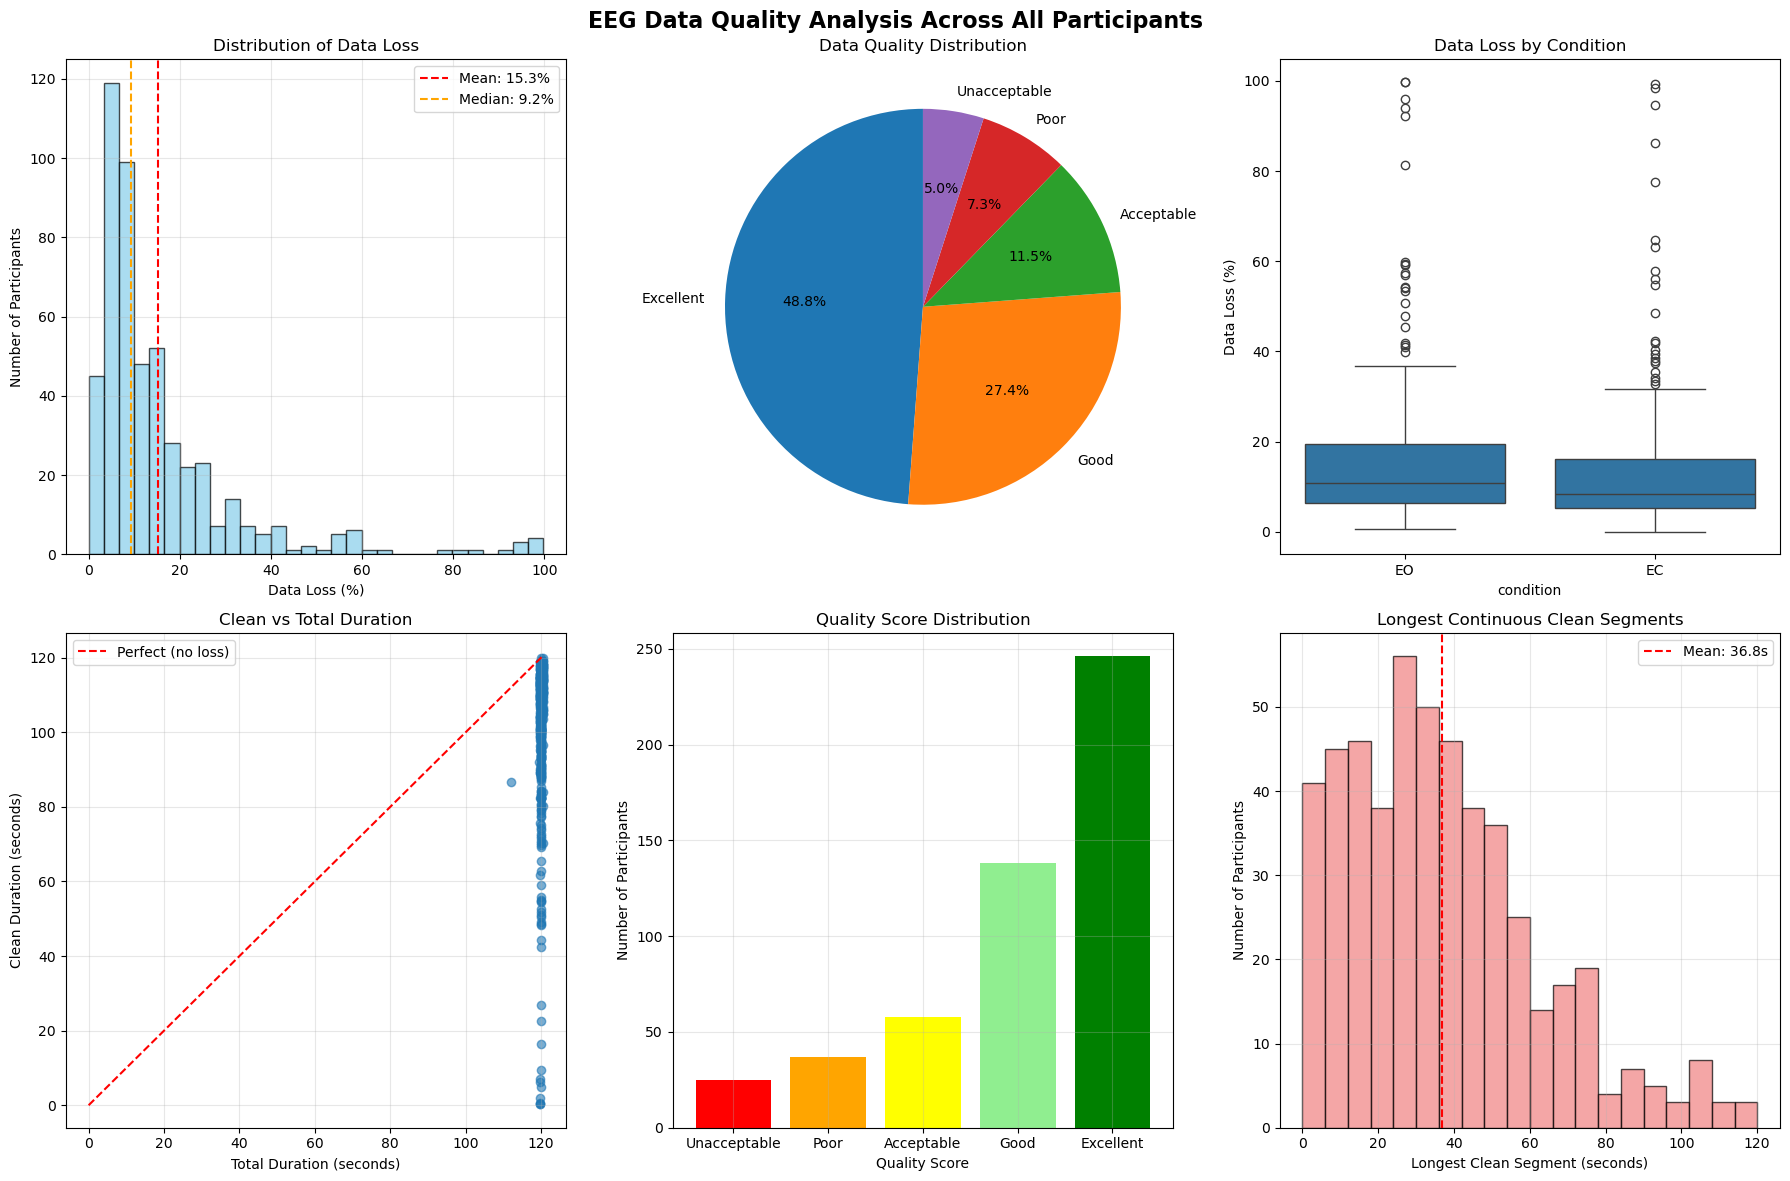

Plots saved to: data_quality_analysis/data_quality_analysis.png
\n=== RECOMMENDATIONS FOR EEG DATA QUALITY ===\n\nGOOD: Your artifact rejection is reasonable but could be optimized.\n   Average data loss is 15.3%, which is acceptable for most analyses.\n   Consider ICA for participants with >20% data loss.\n\n HIGH DATA LOSS: 61 participants (12.1%) have >30% data loss\n   These participants may need:\n   - ICA preprocessing instead of rejection\n   - Manual inspection for excessive artifacts\n   - Possible exclusion from analysis\n\n UNACCEPTABLE QUALITY: 25 participants (5.0%) have >50% data loss\n   These participants should be:\n   - Reprocessed with ICA\n   - Excluded if still poor quality after ICA\n   - Considered for re-recording if possible\n\n🔧 TECHNICAL RECOMMENDATIONS:\n   - 226 participants have longest clean segments <30s\n   - Consider shorter analysis windows or segment-based analysis\n   - Artifact breakdown available in CSV for detailed analysis\n   - 'SWINGsamps' cau

In [2]:
results = run_analysis("/Users/tianyi/Library/Mobile Documents/iCloud~md~obsidian/Documents/my_amanda/PhD/courses/2025_summer/TDBRAIN/preprocessed/")

RECOMMENDATIONS FOR EEG DATA QUALITY
- Average combined loss is 16.1% (temporal: 15.3%, channel: 1.6%)
- Consider ICA for participants with >20% combined loss.

CHANNEL QUALITY ISSUES:
- 225 files (44.6%) have bad channels

SYSTEMATIC CHANNEL ISSUES:
- Most frequently problematic channels:
   - T7: 59 files (11.7%)
   - T8: 56 files (11.1%)
   - Fp2: 45 files (8.9%)
   - These may indicate systematic electrode placement or equipment issues.

HIGH DATA LOSS: 62 files (12.3%) have >30% data loss   
- These participants may need:
    - ICA preprocessing instead of rejection
    - Manual inspection for excessive artifacts
    - Possible exclusion from analysis

UNACCEPTABLE QUALITY: 
25 files (5.0%) have >50% data loss. These participants should be: 
    - Reprocessed with ICA\n   
    - Excluded if still poor quality after ICA
    - Considered for re-recording if possible
    
TECHNICAL RECOMMENDATIONS:
226 participants have longest clean segments <30. Consider shorter analysis windows or segment-based analysis
- Artifact breakdown available in CSV for detailed analysis
- 'SWINGsamps' causes most data loss (9.5% avg)

NEXT STEPS:
1. Review participants with >30% data loss individually
2. Consider implementing ICA preprocessing for high-loss participants
3. Use MNE-Python's AutoReject for more sophisticated artifact handling
4. For ADHD research, consider FOOOF analysis to separate true oscillations from artifacts

# 2. Artifact handling - ICA

In [3]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from tqdm import tqdm
from datetime import datetime
import traceback

## 2.1 Batch ICA processing pipeline

### 2.1.1 Define electrode position

In [4]:
def create_electrode_positions_fixed():
    """Create electrode positions with proper channel name handling"""
    electrode_coords_mm = {
        'Fp1': [-26.81, 84.06, -10.56], 'Fp2': [29.41, 83.74, -10.04],
        'F7': [-66.99, 41.69, -15.96], 'F3': [-48.05, 51.87, 39.87],
        'Fz': [0.90, 57.01, 66.36], 'F4': [50.38, 51.84, 41.33],
        'F8': [68.71, 41.16, -15.31], 'FC3': [-58.83, 21.02, 54.82],
        'FCz': [0.57, 24.63, 87.63], 'FC4': [60.29, 21.16, 55.58],
        'T7': [-83.36, -16.52, -12.65], 'C3': [-65.57, -13.25, 64.98],
        'Cz': [0.23, -11.28, 99.81], 'C4': [66.50, -12.80, 65.11],
        'T8': [84.44, -16.65, -11.79], 'CP3': [-65.51, -48.48, 68.57],
        'CPz': [-0.42, -48.77, 98.37], 'CP4': [65.03, -48.35, 68.57],
        'P3': [-55.07, -80.11, 59.44], 'Pz': [-0.87, -82.23, 82.43],
        'P4': [53.51, -80.13, 59.40], 'O1': [-28.98, -114.52, 9.67],
        'Oz': [-1.41, -117.79, 15.84], 'O2': [26.89, -114.68, 9.45],
        'P7': [-71.46, -75.17, -3.70], 'P8': [71.10, -75.17, -3.69]
    }
    electrode_positions = {ch: np.array([x/1000, y/1000, z/1000]) for ch, (x, y, z) in electrode_coords_mm.items()}
    return electrode_positions

### 2.1.2 Helper functions - anlysis

In [5]:
def find_muscle_components(ica, raw, threshold=0.8):
    """Identify muscle artifact components"""
    muscle_components = []
    sources = ica.get_sources(raw)
    for i in range(ica.n_components_):
        component_data = sources.get_data()[i]
        from scipy.signal import welch
        freqs, psd = welch(component_data, fs=raw.info['sfreq'], nperseg=1024)
        high_freq_mask = (freqs >= 30) & (freqs <= 100)
        total_power = np.trapz(psd, freqs)
        high_freq_power = np.trapz(psd[high_freq_mask], freqs[high_freq_mask])
        if total_power > 0 and (high_freq_power / total_power) > threshold:
            muscle_components.append(i)
    return muscle_components

def find_line_noise_components(ica, raw, line_freq=60, threshold=0.3):
    """Identify line noise components"""
    line_components = []
    sources = ica.get_sources(raw)
    for i in range(ica.n_components_):
        component_data = sources.get_data()[i]
        from scipy.signal import welch
        freqs, psd = welch(component_data, fs=raw.info['sfreq'], nperseg=2048)
        line_idx = np.argmin(np.abs(freqs - line_freq))
        line_power = psd[line_idx]
        total_power = np.mean(psd)
        if line_power / total_power > threshold:
            line_components.append(i)
    return line_components

def calculate_ica_improvement(raw_before, raw_after, removed_components):
    """Calculate improvement metrics"""
    frontal_channels = ['Fp1', 'Fp2', 'F3', 'F4', 'Fz']
    available_frontals = [ch for ch in frontal_channels if ch in raw_before.ch_names]
    if available_frontals:
        before_data = raw_before.copy().pick_types(eeg=True).pick_channels(available_frontals).get_data()
        after_data = raw_after.copy().pick_types(eeg=True).pick_channels(available_frontals).get_data()
        before_var = np.var(before_data)
        after_var = np.var(after_data)
        artifact_reduction = max(0, (1 - after_var / before_var) * 100)
    else:
        artifact_reduction = 0
    return {
        'artifact_reduction': artifact_reduction,
        'components_removed': len(removed_components)
    }

### 2.1.3 Helper functions - plots

In [6]:
def create_comprehensive_ica_plots(ica, raw_filtered, raw_eeg, artifact_components, subject_id, output_dir, verbose=False):
    """Create comprehensive ICA diagnostic plots for each individual"""
    try:
        if verbose:
            print("Creating ICA components overview...")
        fig = ica.plot_components(picks=range(min(20, ica.n_components_)), show=False)
        fig.suptitle(f'ICA Components Overview - {subject_id}', fontsize=16, fontweight='bold')
        plt.savefig(f'{output_dir}/{subject_id}_ica_components_overview.png', dpi=300, bbox_inches='tight')
        plt.close(fig)
        if verbose:
            print(f"Saved: {subject_id}_ica_components_overview.png")
    except Exception as e:
        if verbose:
            print(f"Failed to create components overview: {e}")

    if artifact_components:
        try:
            if verbose:
                print("Creating artifact components analysis...")
            components_to_plot = artifact_components[:min(6, len(artifact_components))]
            fig = ica.plot_properties(raw_filtered, picks=components_to_plot, show=False)
            if isinstance(fig, list):
                for i, f in enumerate(fig):
                    f.suptitle(f'Artifact Component {components_to_plot[i]} - {subject_id}', fontsize=14)
                    plt.figure(f.number)
                    plt.savefig(f'{output_dir}/{subject_id}_artifact_component_{components_to_plot[i]}.png', dpi=300, bbox_inches='tight')
                    plt.close(f)
            else:
                fig.suptitle(f'Artifact Components Properties - {subject_id}', fontsize=16)
                plt.savefig(f'{output_dir}/{subject_id}_artifact_components_properties.png', dpi=300, bbox_inches='tight')
                plt.close(fig)
            if verbose:
                print("Saved artifact component analysis plots")
        except Exception as e:
            if verbose:
                print(f"Failed to create artifact properties: {e}")

    try:
        if verbose:
            print("Creating ICA component activations...")
        ica_sources = ica.get_sources(raw_filtered)
        duration = min(30, ica_sources.times[-1])
        fig = ica_sources.plot(duration=duration, n_channels=min(10, ica.n_components_), title=f'ICA Component Activations - {subject_id}', show=False)
        plt.savefig(f'{output_dir}/{subject_id}_ica_activations.png', dpi=300, bbox_inches='tight')
        plt.close(fig)
        if verbose:
            print(f"Saved: {subject_id}_ica_activations.png")
    except Exception as e:
        if verbose:
            print(f"Failed to create activations plot: {e}")

    try:
        if verbose:
            print("Creating component PSD analysis...")
        if artifact_components:
            ica_sources = ica.get_sources(raw_filtered)
            fig, axes = plt.subplots(len(artifact_components), 1, figsize=(10, 2*len(artifact_components)))
            if len(artifact_components) == 1:
                axes = [axes]
            for i, comp in enumerate(artifact_components):
                from scipy.signal import welch
                freqs, psd = welch(ica_sources.get_data()[comp], fs=raw_filtered.info['sfreq'], nperseg=1024)
                axes[i].semilogy(freqs, psd)
                axes[i].set_title(f'Component {comp} PSD (Artifact)')
                axes[i].set_xlabel('Frequency (Hz)')
                axes[i].set_ylabel('Power (V²/Hz)')
                axes[i].grid(True, alpha=0.3)
                axes[i].set_xlim(0, 50)
            plt.tight_layout()
            plt.suptitle(f'Artifact Components PSD - {subject_id}', fontsize=16, y=1.02)
            plt.savefig(f'{output_dir}/{subject_id}_artifact_components_psd.png', dpi=300, bbox_inches='tight')
            plt.close(fig)
            if verbose:
                print(f"Saved: {subject_id}_artifact_components_psd.png")
    except Exception as e:
        if verbose:
            print(f"Failed to create PSD plots: {e}")

    try:
        if verbose:
            print("Creating component selection summary...")
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        var_explained = np.var(ica.get_sources(raw_filtered).get_data(), axis=1)
        component_numbers = range(len(var_explained))
        colors = ['red' if i in artifact_components else 'blue' for i in component_numbers]
        ax1.bar(component_numbers, var_explained, color=colors, alpha=0.7)
        ax1.set_xlabel('ICA Component')
        ax1.set_ylabel('Variance Explained')
        ax1.set_title('Component Variance (Red = Artifacts)')
        ax1.grid(True, alpha=0.3)
        total_components = len(var_explained)
        kept_components = total_components - len(artifact_components)
        summary_data = [kept_components, len(artifact_components)]
        labels = [f'Kept\n({kept_components})', f'Removed\n({len(artifact_components)})']
        colors_pie = ['lightblue', 'lightcoral']
        ax2.pie(summary_data, labels=labels, colors=colors_pie, autopct='%1.1f%%', startangle=90)
        ax2.set_title('Component Selection Summary')
        plt.suptitle(f'ICA Component Analysis Summary - {subject_id}', fontsize=16)
        plt.tight_layout()
        plt.savefig(f'{output_dir}/{subject_id}_ica_summary.png', dpi=300, bbox_inches='tight')
        plt.close(fig)
        if verbose:
            print(f"Saved: {subject_id}_ica_summary.png")
    except Exception as e:
        if verbose:
            print(f"Failed to create summary plot: {e}")


In [7]:
def create_before_after_plots(raw_before, raw_after, subject_id, output_dir, verbose=False):
    """Create before/after comparison plots"""
    try:
        if verbose:
            print("Creating before/after comparison...")
        raw_before_eeg = raw_before.copy().pick_types(eeg=True)
        raw_after_eeg = raw_after.copy().pick_types(eeg=True)
        channels_to_plot = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4']
        available_channels = [ch for ch in channels_to_plot if ch in raw_before_eeg.ch_names]
        if not available_channels:
            available_channels = raw_before_eeg.ch_names[:6]
        fig, axes = plt.subplots(len(available_channels), 1, figsize=(15, 2*len(available_channels)))
        if len(available_channels) == 1:
            axes = [axes]
        duration = 10
        time_points = int(duration * raw_before_eeg.info['sfreq'])
        times = np.arange(time_points) / raw_before_eeg.info['sfreq']
        for i, ch in enumerate(available_channels):
            ch_idx = raw_before_eeg.ch_names.index(ch)
            before_data = raw_before_eeg.get_data()[ch_idx, :time_points]
            after_data = raw_after_eeg.get_data()[ch_idx, :time_points]
            axes[i].plot(times, before_data, 'r-', alpha=0.7, label='Before ICA', linewidth=0.8)
            axes[i].plot(times, after_data, 'b-', alpha=0.7, label='After ICA', linewidth=0.8)
            axes[i].set_title(f'Channel {ch}')
            axes[i].set_ylabel('Amplitude (µV)')
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
            if i == len(available_channels) - 1:
                axes[i].set_xlabel('Time (seconds)')
        plt.suptitle(f'Before vs After ICA Cleaning - {subject_id}', fontsize=16)
        plt.tight_layout()
        plt.savefig(f'{output_dir}/{subject_id}_before_after_comparison.png', dpi=300, bbox_inches='tight')
        plt.close(fig)
        if verbose:
            print(f"Saved: {subject_id}_before_after_comparison.png")
    except Exception as e:
        if verbose:
            print(f"Failed to create before/after comparison: {e}")
    try:
        if verbose:
            print("Creating PSD comparison...")
        from scipy.signal import welch
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        axes = axes.flatten()
        for i, ch in enumerate(available_channels[:6]):
            ch_idx = raw_before_eeg.ch_names.index(ch)
            freqs, psd_before = welch(raw_before_eeg.get_data()[ch_idx], fs=raw_before_eeg.info['sfreq'], nperseg=2048)
            freqs, psd_after = welch(raw_after_eeg.get_data()[ch_idx], fs=raw_after_eeg.info['sfreq'], nperseg=2048)
            axes[i].semilogy(freqs, psd_before, 'r-', alpha=0.7, label='Before ICA')
            axes[i].semilogy(freqs, psd_after, 'b-', alpha=0.7, label='After ICA')
            axes[i].set_title(f'Channel {ch} PSD')
            axes[i].set_xlabel('Frequency (Hz)')
            axes[i].set_ylabel('Power (V²/Hz)')
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
            axes[i].set_xlim(0, 50)
        plt.suptitle(f'Power Spectral Density Comparison - {subject_id}', fontsize=16)
        plt.tight_layout()
        plt.savefig(f'{output_dir}/{subject_id}_psd_comparison.png', dpi=300, bbox_inches='tight')
        plt.close(fig)
        if verbose:
            print(f"Saved: {subject_id}_psd_comparison.png")
    except Exception as e:
        if verbose:
            print(f"Failed to create PSD comparison: {e}")

### 2.1.4 Run pieline

In [8]:
def comprehensive_ica_pipeline_with_plots(raw, subject_id, save_plots=True, output_dir='ica_results', verbose=False):
    """Complete ICA pipeline with comprehensive diagnostic plots"""
    if verbose:
        print(f"Running ICA pipeline with plots for participant: {subject_id}")
        if save_plots:
            print(f"Plots will be saved to: {output_dir}")
        print("Step 1: Preparing data...")
    raw_eeg = raw.copy().pick_types(eeg=True)
    if verbose:
        print(f"  - Using {len(raw_eeg.ch_names)} EEG channels for ICA: {raw_eeg.ch_names}")
    raw_filtered = raw_eeg.filter(l_freq=1.0, h_freq=40.0, fir_design='firwin')
    if raw_filtered.info['sfreq'] > 500:
        raw_filtered.resample(250)
        if verbose:
            print(f"  - Downsampled to {raw_filtered.info['sfreq']} Hz")
    if verbose:
        print("Step 2: Setting up ICA...")
    n_channels = len(raw_filtered.ch_names)
    n_samples = raw_filtered.n_times
    max_components = min(n_channels, n_samples // 3000)
    n_components = min(20, max_components)
    if verbose:
        print(f"  - Using {n_components} ICA components (from {n_channels} EEG channels)")
    ica = mne.preprocessing.ICA(
        n_components=n_components,
        method='infomax',
        random_state=42,
        max_iter=500,
        fit_params=dict(extended=True)
    )
    if verbose:
        print("Step 3: Fitting ICA...")
    try:
        ica.fit(raw_filtered, verbose=False)
        if verbose:
            print("  - ICA converged successfully")
    except Exception as e:
        if verbose:
            print(f"  - ICA fitting failed: {e}")
            print("  - Trying with different parameters...")
        ica = mne.preprocessing.ICA(
            n_components=n_components-3, 
            method='fastica', 
            random_state=42
        )
        ica.fit(raw_filtered, verbose=False)
    if verbose:
        print("Step 4: Identifying artifact components...")
    artifact_components = []
    try:
        eog_indices, eog_scores = ica.find_bads_eog(raw_filtered, ch_name=['Fp1', 'Fp2'], threshold=2.0)
        artifact_components.extend(eog_indices)
        if verbose:
            print(f"  - Found {len(eog_indices)} EOG-like components: {eog_indices}")
    except Exception as e:
        if verbose:
            print(f"  - EOG detection failed: {e}")
    try:
        ecg_indices, ecg_scores = ica.find_bads_ecg(raw_filtered, threshold='auto')
        artifact_components.extend(ecg_indices)
        if verbose:
            print(f"  - Found {len(ecg_indices)} ECG components: {ecg_indices}")
    except Exception as e:
        if verbose:
            print(f"  - ECG detection failed: {e}")
    muscle_components = find_muscle_components(ica, raw_filtered)
    artifact_components.extend(muscle_components)
    if verbose:
        print(f"  - Found {len(muscle_components)} muscle components: {muscle_components}")
    line_noise_components = find_line_noise_components(ica, raw_filtered)
    artifact_components.extend(line_noise_components)
    if verbose:
        print(f"  - Found {len(line_noise_components)} line noise components: {line_noise_components}")
    artifact_components = list(set(artifact_components))
    if verbose:
        print(f"  - Total artifact components to remove: {len(artifact_components)}")
        print(f"  - Components: {artifact_components}")
    if save_plots:
        create_comprehensive_ica_plots(ica, raw_filtered, raw_eeg, artifact_components, subject_id, output_dir, verbose=verbose)
    ica.exclude = artifact_components
    raw_clean = raw.copy()
    ica.apply(raw_clean)
    if save_plots:
        create_before_after_plots(raw, raw_clean, subject_id, output_dir, verbose=verbose)
    improvement_metrics = calculate_ica_improvement(raw, raw_clean, artifact_components)
    if verbose:
        print("ICA Results:")
        print(f"  - Removed {len(artifact_components)} components ({len(artifact_components)/n_components*100:.1f}%)")
        print(f"  - Preserved {n_components - len(artifact_components)} brain components")
        print(f"  - Artifact reduction: {improvement_metrics['artifact_reduction']:.1f}%")
        if save_plots:
            print(f"All plots saved to: {output_dir}")
    return raw_clean, ica, improvement_metrics

## 2.2 Extract ICA results

In [17]:
def generate_batch_summary_report(results_df, processing_stats, output_directory):
    """
    Generate a summary report for batch ICA processing.
    Saves a text summary and prints key statistics.
    """
    summary_lines = []
    summary_lines.append("=== BATCH ICA SUMMARY REPORT ===\n")
    summary_lines.append(f"Total files processed: {processing_stats.get('total_files', len(results_df))}")
    summary_lines.append(f"Successful: {processing_stats.get('successful', (results_df['processing_status'] == 'Success').sum())}")
    summary_lines.append(f"Failed: {processing_stats.get('failed', (results_df['processing_status'] != 'Success').sum())}")
    summary_lines.append(f"Duration: {processing_stats.get('duration', 'N/A')}\n")

    if 'processing_status' in results_df.columns:
        n_success = (results_df['processing_status'] == 'Success').sum()
        n_failed = (results_df['processing_status'] != 'Success').sum()
        summary_lines.append(f"Success rate: {n_success / len(results_df) * 100:.1f}%")
        summary_lines.append(f"Failure rate: {n_failed / len(results_df) * 100:.1f}%\n")

    if 'components_removed' in results_df.columns:
        summary_lines.append(f"Mean components removed: {results_df['components_removed'].mean():.2f}")
    if 'artifact_reduction' in results_df.columns:
        summary_lines.append(f"Mean artifact reduction: {results_df['artifact_reduction'].mean():.2f}%\n")

    # List failed files if any
    failed = results_df[results_df['processing_status'] != 'Success']
    if not failed.empty:
        summary_lines.append("Failed files:")
        for _, row in failed.iterrows():
            summary_lines.append(f"  - {row.get('filename', 'unknown')}: {row.get('error_message', 'No error message')}")
        summary_lines.append("")

    # Save to file
    summary_path = os.path.join(output_directory, "batch_ica_summary.txt")
    with open(summary_path, "w") as f:
        f.write("\n".join(summary_lines))

    print("\n".join(summary_lines))
    print(f"Batch ICA summary saved to: {summary_path}")

In [18]:
def extract_ica_results(file_path, subject_id, session, condition, raw_clean, ica, metrics):
    """
    Extract summary results from ICA processing for a single participant.
    Returns a dictionary for DataFrame construction.
    """
    # Filename
    filename = os.path.basename(file_path)
    # Number of channels and sampling rate
    n_channels = len(raw_clean.ch_names)
    sfreq = raw_clean.info['sfreq']
    duration_sec = raw_clean.n_times / sfreq

    # ICA metrics
    components_removed = metrics.get('components_removed', len(getattr(ica, 'exclude', [])))
    artifact_reduction = metrics.get('artifact_reduction', None)
    excluded_components = list(getattr(ica, 'exclude', []))

    # Optionally, add more details if available
    ica_method = getattr(ica, 'method', 'unknown')
    n_components = getattr(ica, 'n_components_', None)
    explained_var = None
    try:
        explained_var = np.var(ica.get_sources(raw_clean).get_data(), axis=1).sum() / np.var(raw_clean.get_data())
    except Exception:
        explained_var = None

    # Build result dictionary
    result = {
        'subject_id': subject_id,
        'session': session,
        'condition': condition,
        'filename': filename,
        'processing_status': 'Success',
        'n_channels': n_channels,
        'sampling_rate': sfreq,
        'duration_sec': duration_sec,
        'ica_method': ica_method,
        'n_ica_components': n_components,
        'components_removed': components_removed,
        'excluded_components': ';'.join(map(str, excluded_components)),
        'artifact_reduction': artifact_reduction,
        'ica_explained_variance_ratio': explained_var,
    }
    return result

In [19]:
def single_ica_processing_with_plots(file_path, subjid, save_plots=True, output_dir='ica_results', verbose=False):
    """Full ICA processing with comprehensive diagnostic plots"""
    data = np.load(file_path, allow_pickle=True)
    eeg = data["data"].squeeze()
    fs = float(data["Fs"])
    ch_names = list(data["labels"])
    info = mne.create_info(ch_names=ch_names, sfreq=fs, ch_types='eeg')
    raw = mne.io.RawArray(eeg, info)
    channel_types = {
        'artifacts': 'misc', 'VEOG': 'eog', 'HEOG': 'eog',
        'Erbs': 'misc', 'OrbOcc': 'emg', 'Mass': 'misc'
    }
    channels_to_retype = {ch: ch_type for ch, ch_type in channel_types.items() if ch in ch_names}
    if channels_to_retype:
        raw.set_channel_types(channels_to_retype)
        if verbose:
            print(f"Set channel types: {channels_to_retype}")
    electrode_positions = create_electrode_positions_fixed()
    montage = mne.channels.make_dig_montage(ch_pos=electrode_positions, coord_frame='head')
    raw.set_montage(montage, on_missing='ignore')
    if verbose:
        print("Applied montage to EEG channels, ignored non-EEG channels")
    raw_clean, ica, metrics = comprehensive_ica_pipeline_with_plots(raw, subjid, save_plots, output_dir, verbose=verbose)
    cleaned_eeg = raw_clean.get_data()
    data["ica_cleaned_data"] = cleaned_eeg
    data["ica_excluded_components"] = np.array(ica.exclude)
    save_path = file_path.replace('.npy', '_ica_cleaned.npy')
    np.save(save_path, data)
    if verbose:
        print(f"ICA-cleaned data saved to: {save_path}")
    return raw_clean, ica, metrics

In [20]:
def batch_ica_processing(data_directory, output_directory='batch_ica_results', save_individual_plots=True, max_participants=None, verbose=False):
    """Process all participants with ICA and generate comprehensive reports"""
    print("BATCH ICA PROCESSING FOR ADHD EEG DATA")
    print("="*60)
    os.makedirs(output_directory, exist_ok=True)
    if save_individual_plots:
        plots_dir = os.path.join(output_directory, 'individual_plots')
        os.makedirs(plots_dir, exist_ok=True)
    else:
        plots_dir = None
    pattern = os.path.join(data_directory, "**", "*.npy")
    file_paths = glob.glob(pattern, recursive=True)
    print(f"Found {len(file_paths)} EEG files")
    if max_participants:
        file_paths = file_paths[:max_participants]
        print(f"Processing first {len(file_paths)} participants for testing")
    results = []
    processing_stats = {
        'total_files': len(file_paths),
        'successful': 0,
        'failed': 0,
        'start_time': datetime.now()
    }
    print(f"\nProcessing {len(file_paths)} participants...")
    for i, file_path in enumerate(tqdm(file_paths, desc="Processing participants")):
        try:
            filename = os.path.basename(file_path)
            parts = filename.split('_')
            subject_id = parts[0].replace('sub-', '')
            session = parts[1].replace('ses-', '') if len(parts) > 1 else 'unknown'
            condition = 'EC' if 'EC' in filename else 'EO' if 'EO' in filename else 'Unknown'
            if save_individual_plots:
                participant_plot_dir = os.path.join(plots_dir, f"{subject_id}_{condition}")
                os.makedirs(participant_plot_dir, exist_ok=True)
            else:
                participant_plot_dir = None
            raw_clean, ica, metrics = single_ica_processing_with_plots(
                file_path,
                f"{subject_id}_{condition}",
                save_plots=save_individual_plots,
                output_dir=participant_plot_dir,
                verbose=verbose
            )
            result = extract_ica_results(
                file_path, subject_id, session, condition,
                raw_clean, ica, metrics
            )
            results.append(result)
            processing_stats['successful'] += 1
            del raw_clean, ica
            plt.close('all')
        except Exception as e:
            if verbose:
                print(f"Failed to process {filename}: {str(e)}")
            error_result = {
                'subject_id': subject_id if 'subject_id' in locals() else 'unknown',
                'session': session if 'session' in locals() else 'unknown',
                'condition': condition if 'condition' in locals() else 'unknown',
                'filename': filename,
                'processing_status': 'Failed',
                'error_message': str(e),
                'error_traceback': traceback.format_exc()
            }
            results.append(error_result)
            processing_stats['failed'] += 1
    results_df = pd.DataFrame(results)
    results_csv_path = os.path.join(output_directory, 'batch_ica_results.csv')
    results_df.to_csv(results_csv_path, index=False)
    processing_stats['end_time'] = datetime.now()
    processing_stats['duration'] = processing_stats['end_time'] - processing_stats['start_time']
    generate_batch_summary_report(results_df, processing_stats, output_directory)
    print(f"\nBATCH PROCESSING COMPLETED!")
    print(f"Results: {processing_stats['successful']} successful, {processing_stats['failed']} failed")
    print(f"Duration: {processing_stats['duration']}")
    print(f"All results saved to: {output_directory}")
    return results_df

## 2.3 Run entire ICA pipeline

In [24]:
mne.set_log_level('WARNING')

DATA_DIRECTORY = "/Users/tianyi/Library/Mobile Documents/iCloud~md~obsidian/Documents/my_amanda/PhD/courses/2025_summer/TDBRAIN/preprocessed/"

OUTPUT_DIRECTORY = "batch_ica_adhd_results"

## clean previous result
cleaned_files = glob.glob(os.path.join(DATA_DIRECTORY, "**", "*_cleaned.npy"), recursive=True)
print(f"Found {len(cleaned_files)} files to remove.")
for f in cleaned_files:
    try:
        os.remove(f)
        print(f"Deleted: {f}")
    except Exception as e:
        print(f"Could not delete {f}: {e}")

results_df = batch_ica_processing(
    data_directory=DATA_DIRECTORY,
    output_directory=OUTPUT_DIRECTORY,
    save_individual_plots=False,
    max_participants=None
)

Found 10 files to remove.
Deleted: /Users/tianyi/Library/Mobile Documents/iCloud~md~obsidian/Documents/my_amanda/PhD/courses/2025_summer/TDBRAIN/preprocessed/sub-88044321/ses-1/eeg/sub-88044321_ses-1_task-restEC_eeg_csv_120.016s_ica_cleaned.npy
Deleted: /Users/tianyi/Library/Mobile Documents/iCloud~md~obsidian/Documents/my_amanda/PhD/courses/2025_summer/TDBRAIN/preprocessed/sub-88044321/ses-1/eeg/sub-88044321_ses-1_task-restEO_eeg_csv_120.028s_ica_cleaned.npy
Deleted: /Users/tianyi/Library/Mobile Documents/iCloud~md~obsidian/Documents/my_amanda/PhD/courses/2025_summer/TDBRAIN/preprocessed/sub-87976817/ses-1/eeg/sub-87976817_ses-1_task-restEO_eeg_csv_120.574s_ica_cleaned.npy
Deleted: /Users/tianyi/Library/Mobile Documents/iCloud~md~obsidian/Documents/my_amanda/PhD/courses/2025_summer/TDBRAIN/preprocessed/sub-87976817/ses-1/eeg/sub-87976817_ses-1_task-restEC_eeg_csv_120.578s_ica_cleaned.npy
Deleted: /Users/tianyi/Library/Mobile Documents/iCloud~md~obsidian/Documents/my_amanda/PhD/courses

Processing participants: 100%|██████████| 504/504 [37:03<00:00,  4.41s/it]

=== BATCH ICA SUMMARY REPORT ===

Total files processed: 504
Successful: 504
Failed: 0
Duration: 0:37:03.476627

Success rate: 100.0%
Failure rate: 0.0%

Mean components removed: 2.71
Mean artifact reduction: 47.22%

Batch ICA summary saved to: batch_ica_adhd_results/batch_ica_summary.txt

BATCH PROCESSING COMPLETED!
Results: 504 successful, 0 failed
Duration: 0:37:03.476627
All results saved to: batch_ica_adhd_results


In [25]:
results_df

,subject_id,session,condition,filename,processing_status,n_channels,sampling_rate,duration_sec,ica_method,n_ica_components,components_removed,excluded_components,artifact_reduction,ica_explained_variance_ratio
0,88044321,1,EO,sub-88044321_ses-1_task-restEO_eeg_csv_120.028...,Success,32,500.0,120.028,infomax,20,5,0;1;4;7;15,78.938365,0.012770
1,88044321,1,EC,sub-88044321_ses-1_task-restEC_eeg_csv_120.016...,Success,32,500.0,120.016,infomax,20,5,0;3;6;10;15,83.423061,0.008550
2,87976817,1,EO,sub-87976817_ses-1_task-restEO_eeg_csv_120.574...,Success,32,500.0,120.574,infomax,20,2,4;7,25.761345,0.071916
3,87976817,1,EC,sub-87976817_ses-1_task-restEC_eeg_csv_120.578...,Success,32,500.0,120.578,infomax,20,4,0;8;4;14,69.835428,0.051413
4,88064345,1,EO,sub-88064345_ses-1_task-restEO_eeg_csv_119.668...,Success,32,500.0,119.668,infomax,19,4,0;16;12;5,59.020431,0.048582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,88058361,1,EC,sub-88058361_ses-1_task-restEC_eeg_csv_119.682...,Success,32,500.0,119.682,infomax,19,2,13;7,22.496716,0.077079
500,87980373,1,EC,sub-87980373_ses-1_task-restEC_eeg_csv_120.574...,Success,32,500.0,120.574,infomax,20,3,2;4;6,56.083887,0.085540
501,87980373,1,EO,sub-87980373_ses-1_task-restEO_eeg_csv_120.644...,Success,32,500.0,120.644,infomax,20,3,2;3;14,45.669281,0.053822
502,88022177,1,EC,sub-88022177_ses-1_task-restEC_eeg_csv_120.028...,Success,32,500.0,120.028,infomax,20,3,0;4;6,49.330704,0.181275


# 3. Biomarker extraction

In [37]:
import numpy as np
import pandas as pd
from scipy.signal import welch
from scipy.integrate import simpson
import os
import glob
from fooof import FOOOF

In [38]:
def extract_adhd_biomarkers_from_file(cleaned_file, verbose=False):
    """
    Extract ADHD biomarkers from a single ICA-cleaned EEG file, including FOOOF features.
    """
    try:
        data = np.load(cleaned_file, allow_pickle=True).item()
        eeg = data["ica_cleaned_data"] if "ica_cleaned_data" in data else data["data"]
        fs = float(data["Fs"])
        ch_names = list(data["labels"])
        filename = os.path.basename(cleaned_file)
        subject_id = filename.split('_')[0].replace('sub-', '')
        condition = 'EC' if 'EC' in filename else 'EO' if 'EO' in filename else 'Unknown'

        # Only use EEG channels (exclude non-EEG if present)
        eeg_indices = [i for i, ch in enumerate(ch_names) if ch not in ['VEOG', 'HEOG', 'Erbs', 'OrbOcc', 'Mass', 'artifacts']]
        eeg_data = eeg[eeg_indices, :]
        eeg_ch_names = [ch_names[i] for i in eeg_indices]

        biomarkers = {
            'subject_id': subject_id,
            'condition': condition,
            'sampling_rate': fs,
            'n_channels': len(eeg_ch_names),
            'duration_sec': eeg_data.shape[1] / fs,
            'filename': filename
        }

        # Define frequency bands
        freq_bands = {
            'delta': (0.5, 4),
            'theta': (4, 8),
            'alpha': (8, 13),
            'beta': (13, 30),
            'low_beta': (13, 20),
            'high_beta': (20, 30),
            'gamma': (30, 45)
        }

        # Compute PSD, band powers, and FOOOF features
        for i, ch in enumerate(eeg_ch_names):
            freqs, psd = welch(eeg_data[i], fs=fs, nperseg=int(fs*4), noverlap=int(fs*2), window='hann')
            freq_mask = (freqs >= 1) & (freqs <= 40)
            freqs = freqs[freq_mask]
            psd = psd[freq_mask]
            total_power = simpson(psd, freqs)
            biomarkers[f'{ch}_total_power'] = total_power
            for band, (fmin, fmax) in freq_bands.items():
                band_mask = (freqs >= fmin) & (freqs <= fmax)
                band_power_abs = simpson(psd[band_mask], freqs[band_mask]) if np.any(band_mask) else 0
                band_power_rel = (band_power_abs / total_power) * 100 if total_power > 0 else 0
                biomarkers[f'{ch}_{band}_abs'] = band_power_abs
                biomarkers[f'{ch}_{band}_rel'] = band_power_rel
            # Theta/beta ratio
            theta = biomarkers[f'{ch}_theta_abs']
            beta = biomarkers[f'{ch}_beta_abs']
            biomarkers[f'{ch}_theta_beta_ratio'] = theta / beta if beta > 0 else np.nan
            # Individual alpha frequency
            alpha_mask = (freqs >= 8) & (freqs <= 13)
            if np.any(alpha_mask):
                alpha_freqs = freqs[alpha_mask]
                alpha_psd = psd[alpha_mask]
                peak_idx = np.argmax(alpha_psd)
                biomarkers[f'{ch}_individual_alpha_freq'] = alpha_freqs[peak_idx]
                biomarkers[f'{ch}_alpha_peak_power'] = alpha_psd[peak_idx]
            else:
                biomarkers[f'{ch}_individual_alpha_freq'] = np.nan
                biomarkers[f'{ch}_alpha_peak_power'] = np.nan

            # --- FOOOF features ---
            try:
                fm = FOOOF(peak_width_limits=[1, 12], max_n_peaks=6, min_peak_height=0.1, verbose=False)
                fm.fit(freqs, psd)
                # Aperiodic (1/f) features
                biomarkers[f'{ch}_fooof_offset'] = fm.aperiodic_params_[0] if fm.aperiodic_params_ is not None else np.nan
                biomarkers[f'{ch}_fooof_exponent'] = fm.aperiodic_params_[1] if fm.aperiodic_params_ is not None else np.nan
                biomarkers[f'{ch}_fooof_r2'] = fm.r_squared_
                # Peak features (largest peak in alpha band, if any)
                alpha_peaks = [pk for pk in fm.peak_params_ if 8 <= pk[0] <= 13] if fm.peak_params_ is not None else []
                if alpha_peaks:
                    peak = max(alpha_peaks, key=lambda x: x[1])  # [CF, PW, BW]
                    biomarkers[f'{ch}_fooof_alpha_cf'] = peak[0]
                    biomarkers[f'{ch}_fooof_alpha_pw'] = peak[1]
                    biomarkers[f'{ch}_fooof_alpha_bw'] = peak[2]
                else:
                    biomarkers[f'{ch}_fooof_alpha_cf'] = np.nan
                    biomarkers[f'{ch}_fooof_alpha_pw'] = np.nan
                    biomarkers[f'{ch}_fooof_alpha_bw'] = np.nan
            except Exception as fe:
                if verbose:
                    print(f"FOOOF failed for {ch}: {fe}")
                biomarkers[f'{ch}_fooof_offset'] = np.nan
                biomarkers[f'{ch}_fooof_exponent'] = np.nan
                biomarkers[f'{ch}_fooof_r2'] = np.nan
                biomarkers[f'{ch}_fooof_alpha_cf'] = np.nan
                biomarkers[f'{ch}_fooof_alpha_pw'] = np.nan
                biomarkers[f'{ch}_fooof_alpha_bw'] = np.nan

        # Composite/global indices (example: global theta/beta ratio)
        tbrs = [biomarkers[f'{ch}_theta_beta_ratio'] for ch in eeg_ch_names if not np.isnan(biomarkers[f'{ch}_theta_beta_ratio'])]
        biomarkers['global_theta_beta_ratio_mean'] = np.mean(tbrs) if tbrs else np.nan

        if verbose:
            print(f"Extracted biomarkers for {subject_id} ({condition})")

        return biomarkers

    except Exception as e:
        if verbose:
            print(f"Failed to extract biomarkers from {cleaned_file}: {e}")
        return {'filename': cleaned_file, 'error': str(e)}

In [42]:
DATA_DIRECTORY = "/Users/tianyi/Library/Mobile Documents/iCloud~md~obsidian/Documents/my_amanda/PhD/courses/2025_summer/TDBRAIN/preprocessed/"
OUTPUT_DIRECTORY = "adhd_biomarkers_results"

biomarkers_df = run_biomarker_extraction(
    data_directory=DATA_DIRECTORY,
    output_directory=OUTPUT_DIRECTORY,
    max_participants=None,  # or None for all
    verbose=False
)

Starting biomarker extraction in: /Users/tianyi/Library/Mobile Documents/iCloud~md~obsidian/Documents/my_amanda/PhD/courses/2025_summer/TDBRAIN/preprocessed/
🧠 BATCH ADHD BIOMARKER EXTRACTION
Found 504 cleaned EEG files.


Extracting biomarkers: 100%|██████████| 504/504 [04:29<00:00,  1.87it/s]


Biomarkers saved to: adhd_biomarkers_results/adhd_biomarkers.csv


In [43]:
biomarkers_df

,subject_id,condition,sampling_rate,n_channels,duration_sec,filename,Fp1_total_power,Fp1_delta_abs,Fp1_delta_rel,Fp1_theta_abs,...,O2_theta_beta_ratio,O2_individual_alpha_freq,O2_alpha_peak_power,O2_fooof_offset,O2_fooof_exponent,O2_fooof_r2,O2_fooof_alpha_cf,O2_fooof_alpha_pw,O2_fooof_alpha_bw,global_theta_beta_ratio_mean
0,88044321,EC,500.0,26,120.016,sub-88044321_ses-1_task-restEC_eeg_csv_120.016...,28.180482,9.685684,34.370186,7.730094,...,3.737561,9.25,330.511041,2.013367,1.392788,0.980401,9.256557,1.670990,1.679825,3.303435
1,88044321,EO,500.0,26,120.028,sub-88044321_ses-1_task-restEO_eeg_csv_120.028...,89.430857,22.143989,24.761016,8.675144,...,2.441302,9.50,3.908214,1.318234,1.571131,0.993644,9.552789,0.782864,2.550856,2.235078
2,87976817,EO,500.0,26,120.574,sub-87976817_ses-1_task-restEO_eeg_csv_120.574...,20.775201,6.214399,29.912581,2.523195,...,0.548184,10.25,3.689331,1.053337,1.208656,0.988795,9.719513,0.645226,3.029210,0.544421
3,87976817,EC,500.0,26,120.578,sub-87976817_ses-1_task-restEC_eeg_csv_120.578...,18.309868,3.867674,21.123438,2.123211,...,0.463983,11.50,21.129557,1.113893,1.109981,0.984067,11.763823,1.306258,1.767739,0.489946
4,88064345,EO,500.0,26,119.668,sub-88064345_ses-1_task-restEO_eeg_csv_119.668...,34.911433,7.163206,20.518223,3.600683,...,2.801223,9.25,23.736443,1.653779,1.432537,0.975605,9.387593,0.952393,2.238404,2.588938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,88058361,EC,500.0,26,119.682,sub-88058361_ses-1_task-restEC_eeg_csv_119.682...,60.342812,21.262727,35.236553,20.937419,...,2.170461,10.00,11.190431,1.022652,1.181205,0.976085,9.939964,1.177857,1.051194,6.846814
500,87980373,EC,500.0,26,120.574,sub-87980373_ses-1_task-restEC_eeg_csv_120.574...,12.206353,2.360825,19.340953,1.787992,...,0.400049,10.00,15.490217,0.609091,0.894970,0.982506,11.812118,1.402983,1.044005,0.558951
501,87980373,EO,500.0,26,120.644,sub-87980373_ses-1_task-restEO_eeg_csv_120.644...,19.784763,6.622775,33.474116,3.471942,...,0.598446,10.25,2.300919,0.659019,0.991852,0.977031,10.116615,0.662903,1.000000,0.713788
502,88022177,EO,500.0,26,120.040,sub-88022177_ses-1_task-restEO_eeg_csv_120.04s...,7.973202,1.865295,23.394553,0.829162,...,0.723426,10.50,0.811883,0.574954,0.976857,0.971870,10.536603,0.317855,1.000000,0.551503


NameError: name 'cat' is not defined